In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/manojmanivannan/machine-learning-with-PyTorch/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
    IS_COLAB = True
except ModuleNotFoundError:
    IS_COLAB = False
    pass

from config import *
import_from_github(dataset=1)

In [74]:
# installing feature engine
%pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ------------------------------------ 260.6/260.6 kB 887.7 kB/s eta 0:00:00
     ---------------------------------------- 9.0/9.0 MB 1.5 MB/s eta 0:00:00
     ------------------------------------- 233.7/233.7 kB 14.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [77]:
from prediction_models.genericRegressionClassification import *
from plots.stage1 import *
import pandas as pd
from explore.analytics import correlation_matrix, get_principle_component
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from feature_engine.creation import CyclicalFeatures

# read the dataset using pandas

dataset_path = '/dataset/power_plant/pp_data.csv'
dataset_path_actual = '..'+dataset_path if not IS_COLAB else dataset_path
df = pd.read_csv(dataset_path_actual, sep=',', header=0)

In [25]:
#Check to see if there are missing data
print(df.isnull().values.any())

# Features consist of hourly average ambient variables
# - Temperature (AT) in the range 1.81°C and 37.11°C,
# - Ambient Pressure (AP) in the range 992.89-1033.30 millibar,
# - Relative Humidity (RH) in the range 25.56% to 100.16%
# - Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
# - Net hourly electrical energy output (PE) 420.26-495.76 MW
# The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.
df.head()

False


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [28]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [30]:
# Dropping duplicated records
df = df.drop_duplicates(keep=False)

array([[<AxesSubplot:title={'center':'AT'}>,
        <AxesSubplot:title={'center':'V'}>],
       [<AxesSubplot:title={'center':'AP'}>,
        <AxesSubplot:title={'center':'RH'}>],
       [<AxesSubplot:title={'center':'PE'}>, <AxesSubplot:>]],
      dtype=object)

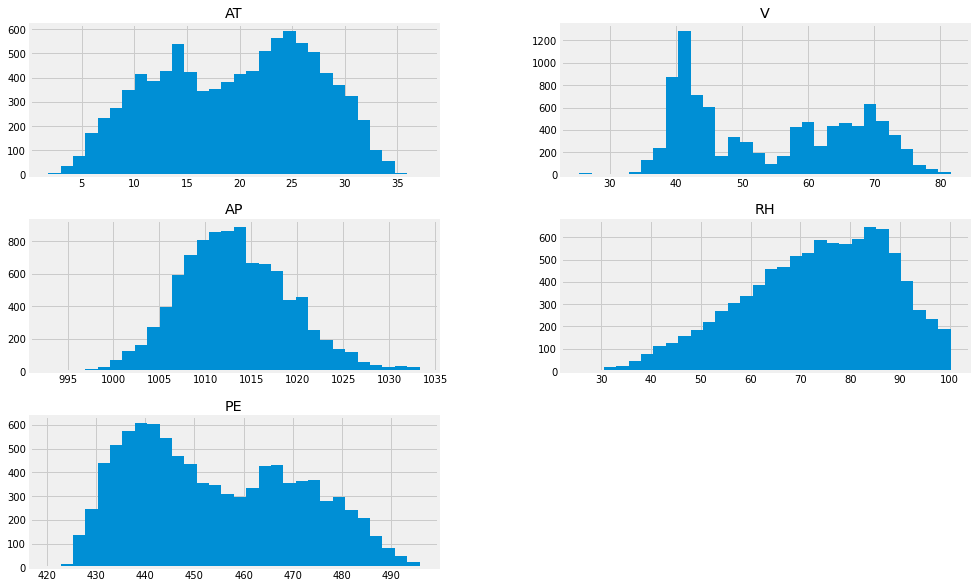

In [31]:
df.hist(bins=30,figsize=(15, 10))

#### Histogram inference
Looking at the histograms we draw some inferences
##### Ambient Temperature (AT)
The ambient temperature histogram is bimodal distribution. In reality it is actually two unimodal (one-peaked) distributions.
since the dataset contains data points across a year ( in fact: 6 years (2006-2011)), that peaks reference to temperature swings 
between the summer and winter.
##### Ambient Pressure (AP)
The ambient pressure histogram shows us that the pressure is greatly remained around a mean of 1013 millibars
##### Relative Humidity
The RH is right shifted, showing that is a more humid location where is power plant is located

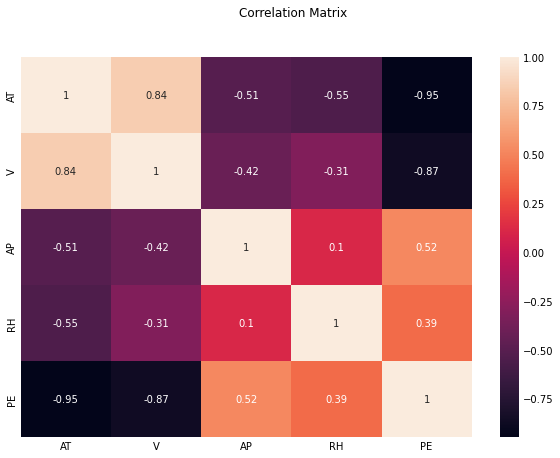

,AT,V,AP,RH,PE
AT,1.000000,0.843268,-0.508902,-0.545380,-0.947685
V,0.843268,1.000000,-0.417975,-0.312240,-0.870029
AP,-0.508902,-0.417975,1.000000,0.103717,0.518945
RH,-0.545380,-0.312240,0.103717,1.000000,0.392581
PE,-0.947685,-0.870029,0.518945,0.392581,1.000000


In [32]:
correlation_matrix(df,plot=True)

It appears that there are several strong correlations. The Energy produced (PE) is strongly correlated with ambient temperature (AT) and exhaust vacuum (V)
Let's look at them visually

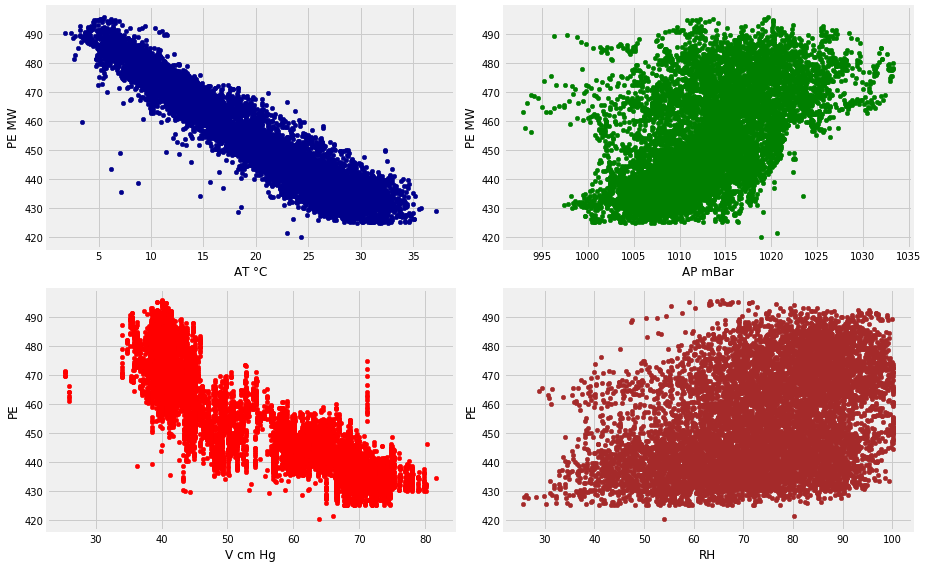

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(13,8))

df.plot.scatter(x='AT', y='PE', c='DarkBlue', ax=axes[0,0]); axes[0,0].set_xlabel(r'AT $\degree$C'); axes[0,0].set_ylabel('PE MW')
df.plot.scatter(x='AP', y='PE', c='green', ax=axes[0,1]); axes[0,1].set_xlabel(r'AP mBar'); axes[0,1].set_ylabel('PE MW');
df.plot.scatter(x='V', y='PE', c='red', ax=axes[1,0]); axes[1,0].set_xlabel(r'V cm Hg'); axes[0,1].set_ylabel('PE MW');
df.plot.scatter(x='RH', y='PE', c='brown', ax=axes[1,1]) ; axes[1,1].set_xlabel(r'RH'); axes[0,1].set_ylabel('PE MW');
fig.tight_layout()

In [81]:
sf_tansformer = CyclicalFeatures()
df_cf = sf_tansformer.fit_transform(df)

In [82]:
df_cf

,AT,V,AP,RH,PE,AT_sin,AT_cos,V_sin,V_cos,AP_sin,AP_cos,RH_sin,RH_cos,PE_sin,PE_cos
0,8.34,40.77,1010.84,90.01,480.48,0.987429,0.158065,0.000770,-1.000000,-0.136148,0.990688,-0.594565,0.804048,-0.192448,0.981307
1,23.64,58.49,1011.40,74.20,445.75,-0.758465,-0.651714,-0.978763,-0.204997,-0.132774,0.991146,-0.998335,-0.057681,-0.592226,0.805772
2,29.74,56.90,1007.15,41.91,438.76,-0.948299,0.317378,-0.946382,-0.323050,-0.158341,0.987384,0.490372,-0.871513,-0.661194,0.750215
3,19.07,49.69,1007.22,76.79,453.09,-0.087085,-0.996201,-0.633760,-0.773529,-0.157921,0.987452,-0.994518,0.104570,-0.514816,0.857301
4,11.80,40.66,1017.13,97.20,464.43,0.910175,-0.414225,0.009244,-0.999957,-0.098167,0.995170,-0.184620,0.982810,-0.386719,0.922197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59,0.549352,-0.835591,-0.586788,-0.809741,-0.130363,0.991466,-0.990578,-0.136950,-0.408118,0.912929
9564,33.41,77.95,1010.30,59.72,432.90,-0.586277,0.810110,-0.274535,0.961577,-0.139401,0.990236,-0.568541,-0.822655,-0.715038,0.699086
9565,15.99,43.34,1014.20,78.66,465.96,0.420763,-0.907171,-0.195940,-0.980616,-0.115880,0.993263,-0.975444,0.220249,-0.368766,0.929522
9566,17.65,59.87,1018.58,94.65,450.93,0.152629,-0.988284,-0.994989,-0.099982,-0.089388,0.995997,-0.338809,0.940855,-0.538089,0.842888


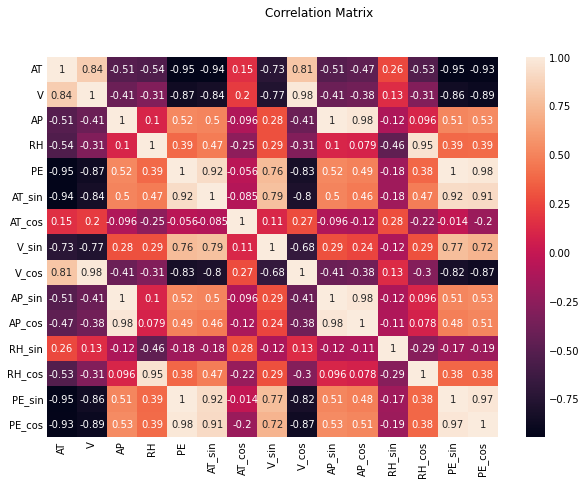

,AT,V,AP,RH,PE,AT_sin,AT_cos,V_sin,V_cos,AP_sin,AP_cos,RH_sin,RH_cos,PE_sin,PE_cos
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128,-0.942736,0.149193,-0.734283,0.808117,-0.507931,-0.473739,0.259459,-0.527442,-0.946173,-0.934926
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780,-0.841109,0.203272,-0.773276,0.981642,-0.413855,-0.383532,0.132955,-0.306525,-0.860334,-0.887601
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429,0.498632,-0.096279,0.284974,-0.409614,0.999995,0.976969,-0.118447,0.096017,0.512009,0.530229
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794,0.465661,-0.253326,0.286788,-0.305084,0.099843,0.079420,-0.463743,0.954292,0.386430,0.393096
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000,0.922679,-0.055835,0.761429,-0.833001,0.518742,0.489598,-0.177709,0.382999,0.998590,0.982620
AT_sin,-0.942736,-0.841109,0.498632,0.465661,0.922679,1.000000,-0.084875,0.785449,-0.799744,0.499103,0.459015,-0.177158,0.468762,0.921849,0.913112
AT_cos,0.149193,0.203272,-0.096279,-0.253326,-0.055835,-0.084875,1.000000,0.109109,0.272974,-0.095907,-0.123990,0.281227,-0.215549,-0.013977,-0.201652
V_sin,-0.734283,-0.773276,0.284974,0.286788,0.761429,0.785449,0.109109,1.000000,-0.678872,0.285564,0.239365,-0.117965,0.285828,0.770664,0.721298
V_cos,0.808117,0.981642,-0.409614,-0.305084,-0.833001,-0.799744,0.272974,-0.678872,1.000000,-0.409915,-0.383526,0.128322,-0.299629,-0.819287,-0.865715
AP_sin,-0.507931,-0.413855,0.999995,0.099843,0.518742,0.499103,-0.095907,0.285564,-0.409915,1.000000,0.976332,-0.118564,0.096256,0.512346,0.530465


In [83]:
correlation_matrix(df_cf,plot=True)

Using 3 components, we can explain 97.44% of the variability in the original data.


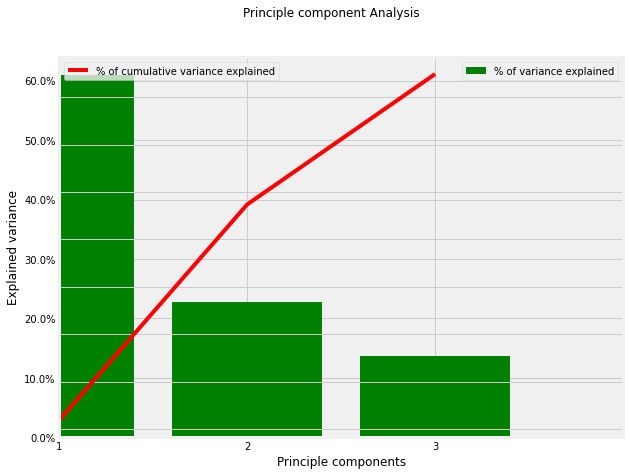

In [84]:
pca,n_components = get_principle_component(df.drop('PE',axis=1),least_components=1,least_explained_variance=0.90,plot=True)
pca_df = pd.DataFrame(pca.fit_transform(df.drop('PE',axis=1)),columns=[f'PC-{i}' for i in range(1,n_components+1)])
choosen_columns = pca_df.columns

In [85]:
pca = PCA(n_components=1)
pca.fit(np.array(df[['V','AT']]))
print("variance explained : ",pca.explained_variance_ratio_)

y = pca.transform(np.array(df[['V','AT']]))
new_component = pd.DataFrame(y)
new_component = new_component.rename(columns={0: 'new_component'})
df["new_component"] = new_component
df.drop(['V','AT'], axis=1, inplace=True)

variance explained :  [0.94187985]


In [86]:
df

,AP,RH,PE,new_component
0,1010.84,90.01,480.48,17.276408
1,1011.40,74.20,445.75,-5.573358
2,1007.15,41.91,438.76,-7.058299
3,1007.22,76.79,453.09,4.341589
4,1017.13,97.20,464.43,15.736477
...,...,...,...,...
9563,1011.80,72.93,462.59,6.888626
9564,1010.30,59.72,432.90,-27.339992
9565,1014.20,78.66,465.96,11.393150
9566,1018.58,94.65,450.93,-3.955442


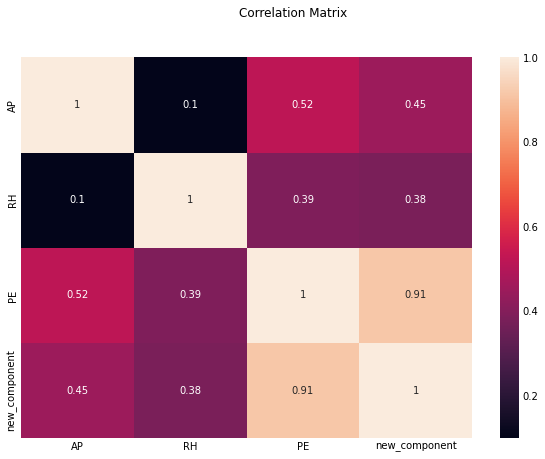

,AP,RH,PE,new_component
AP,1.000000,0.099574,0.518429,0.448959
RH,0.099574,1.000000,0.389794,0.378249
PE,0.518429,0.389794,1.000000,0.914900
new_component,0.448959,0.378249,0.914900,1.000000


In [87]:
correlation_matrix(df,plot=True)

In [88]:
df_feature = df.drop(['PE'],axis=1)
df_target = df['PE']

At this point, the pca_df, which is a principle components data, can be used as the feature. but for now, I will go with the original features + the new_component

In [91]:
X_train,X_val,y_train,y_val = train_test_split(df_feature,df_target,test_size=0.2, random_state=13)
# X_train,X_val,y_train,y_val = train_test_split(pca_df,df_target,test_size=0.2, random_state=13)

sc_feature = StandardScaler()
sc_feature.fit(X_train)
X_train = sc_feature.transform(X_train)
X_val = sc_feature.transform(X_val)

# sc_target = StandardScaler()
# sc_target.fit(y_train.values.reshape(-1,1))
# y_train = sc_target.transform(y_train.values.reshape(-1,1))
# y_val = sc_target.transform(y_val.values.reshape(-1,1))

y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)


In [17]:
# fig = figure1(X_train, y_train, X_val, y_val); plt.show() # works only for if there is one feature

In [92]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100)

In [93]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.02

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(len(choosen_columns), 1))
# model.add_module('linear1', nn.Linear(3, 1))


# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 0.4414,  0.4792, -0.1353]])), ('0.bias', tensor([0.5304]))])


In [94]:
# Clear the tensorboard logs directory
import shutil
try:
    shutil.rmtree('runs')
except FileNotFoundError:
    pass

In [95]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('powerplant')
sbs.train(n_epochs=200)

print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 2.5081,  0.9809, 13.9719]], device='cuda:0')), ('0.bias', tensor([454.2639], device='cuda:0'))])


In [96]:
%load_ext tensorboard
%tensorboard --port 7000 --logdir runs

In [97]:
# Evalute the model on the training set
y_train_predictions = sbs.predict(x_train_tensor)
y_train_actual = y_train_tensor.detach().cpu().numpy()
train_mse = mean_squared_error(y_train_predictions,y_train_actual)

y_val_predictions = sbs.predict(x_val_tensor)
y_val_actual = y_val_tensor.detach().cpu().numpy()
val_mse = mean_squared_error(y_val_predictions,y_val_actual)

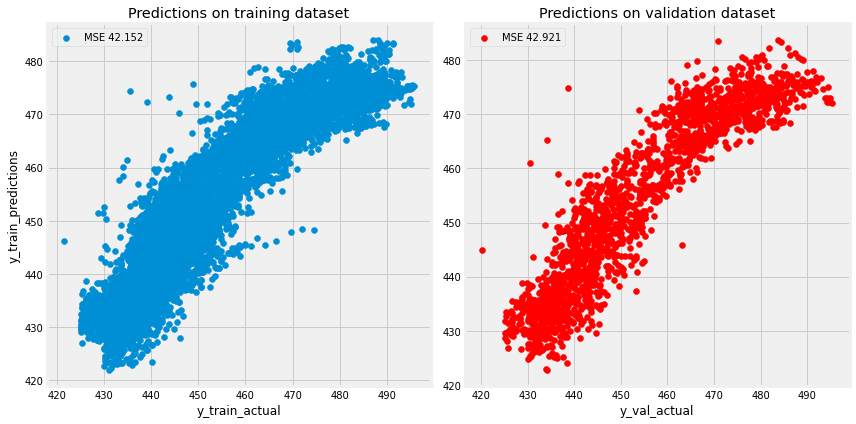

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(y_train_actual,y_train_predictions)
ax[0].set_xlabel('y_train_actual')
ax[0].set_ylabel('y_train_predictions')

ax[0].set_title('Predictions on training dataset')
ax[0].legend([f'MSE {mean_squared_error(y_train_predictions,y_train_actual):.3f}'])

ax[1].scatter(y_val_actual,y_val_predictions, c='r')
ax[1].set_xlabel('y_val_actual')
# ax[1].set_ylabel('y_val_predictions')

ax[1].set_title('Predictions on validation dataset')
ax[1].legend([f'MSE {mean_squared_error(y_val_predictions,y_val_actual):.3f}'])
fig.tight_layout()